In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import rioxarray
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm
import copy
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


TODOs:
- Using Square images rather than masked ones
- 

In [7]:
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white

def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def label_csv_2(clean_img_path):
    #only for saturday and sunday
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        if find_day(date_string) == 'Saturday' or find_day(date_string) == 'Sunday':
            df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
            
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image

def extract_random_patches(image, patch_size=(20, 20), num_patches=10, threshold=50):
    patches = []
    image_height, image_width = image.shape[:2]
    patch_height, patch_width = patch_size

    
    while len(patches) < num_patches:
        # Generate random coordinates for the top-left corner of the patch
        start_h = np.random.randint(0, image_height - patch_height + 1)
        start_w = np.random.randint(0, image_width - patch_width + 1)
        
        # Extract the patch using slicing
        patch = image[start_h:start_h + patch_height, start_w:start_w + patch_width]
        if (patch == 0).sum()/(patch_height*patch_height*3) < threshold/100:  #removes black patches
            patches.append(patch)
        else:
            pass
    
    return patches


#### Individual parking lots

In [79]:
img_path = "/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_538_bbox/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 500
Most common size of the dataset (4, 123, 39)
Final size of dataset(after removing faulty size images) 498
Final size of dataset(after removing faulty black pixels in images) 487
Final size of dataset(after removing faulty white pixels in images) 332


Number of images removed by clean_data_by_size function: 11
Number of images removed by clean_data_by_black_pixels function: 155


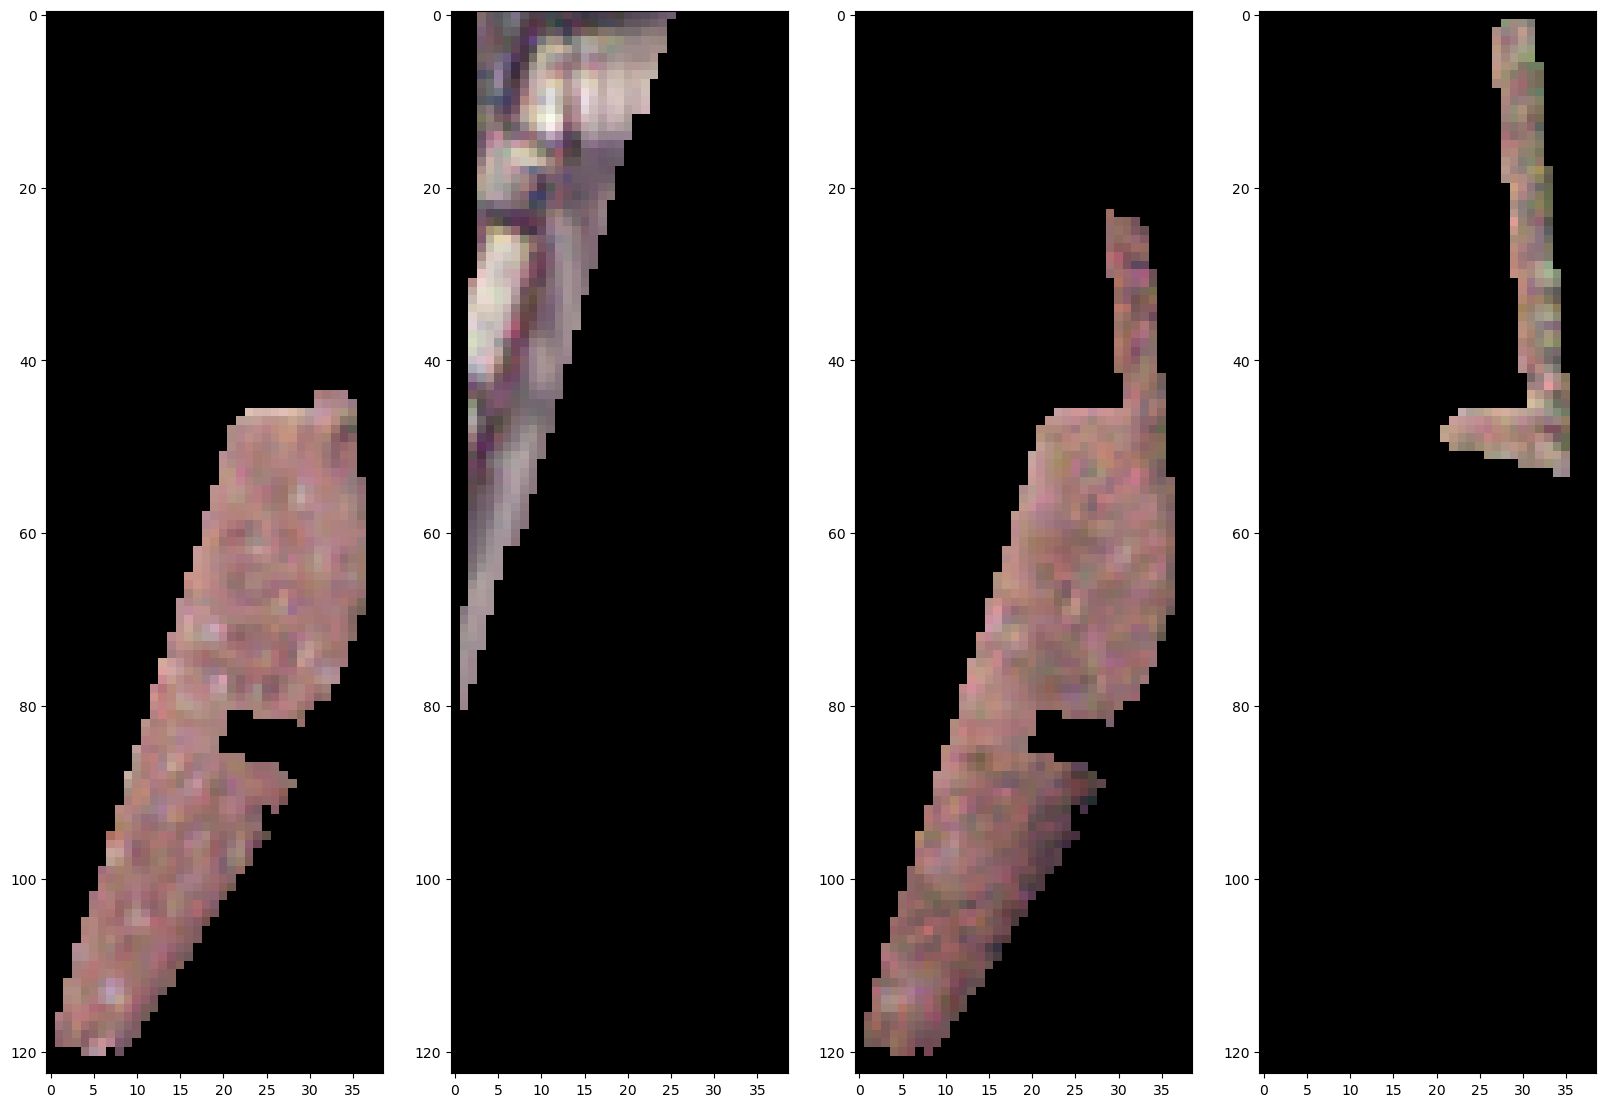

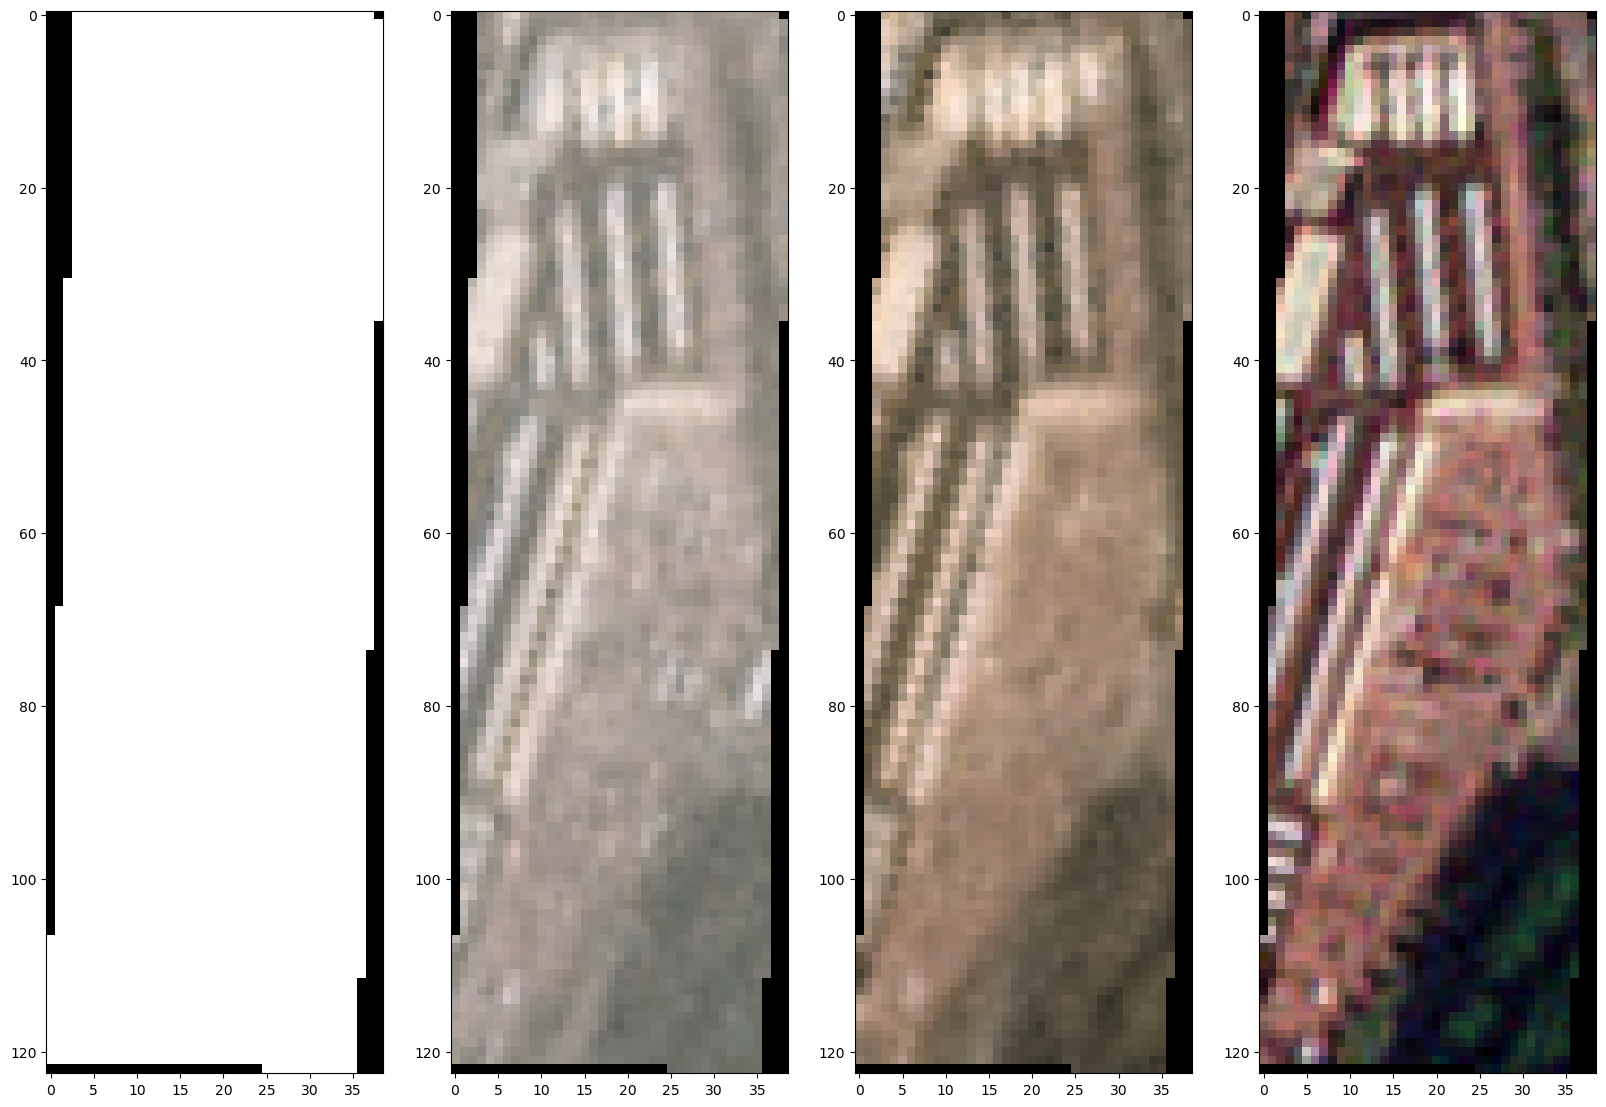

In [88]:
#difference between clean_2 and clean_1 and names
print("Number of images removed by clean_data_by_size function:", len(clean_1)-len(clean_2))
diff = list(set(clean_1) - set(clean_2))
#plot 4 elements from diff
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    img = rioxarray.open_rasterio(diff[i])
    ax[i].imshow(img.data[0:3].transpose(1, 2, 0))
    # ax[i].set_title(diff[i].split('/')[-1])
print("Number of images removed by clean_data_by_black_pixels function:", len(clean_2)-len(clean_3))
diff = list(set(clean_2) - set(clean_3))
#plot 4 elements from diff
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    img = rioxarray.open_rasterio(diff[i])
    ax[i].imshow(img.data[0:3].transpose(1, 2, 0))
    # ax[i].set_title(diff[i].split('/')[-1])

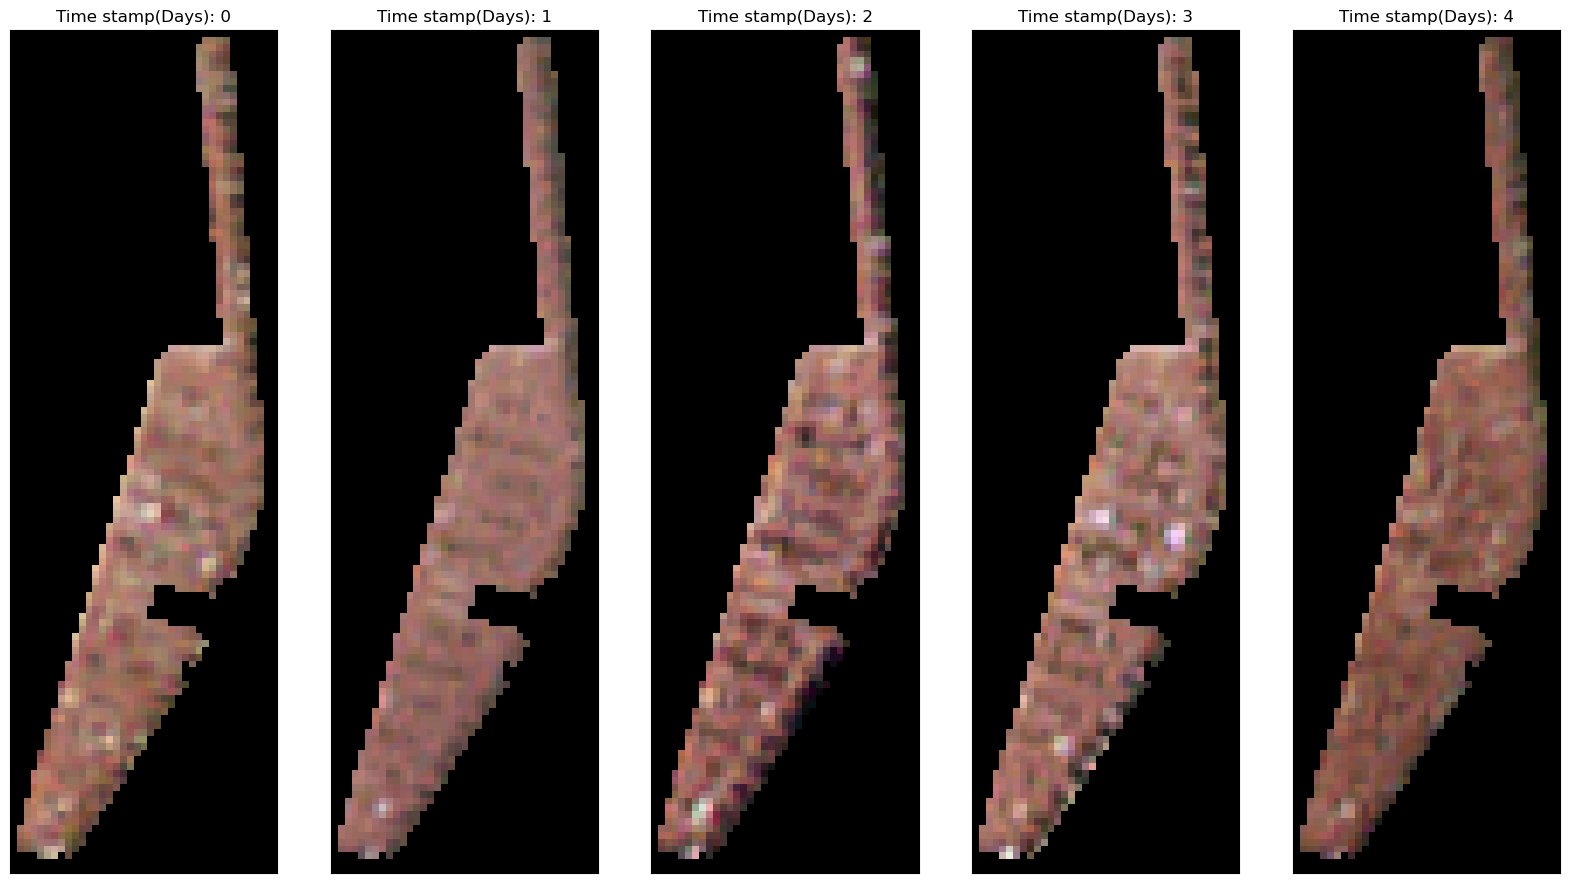

In [30]:
masked_clean = [i for i in clean_3 if 'Masked' in i]
square_clean = [i for i in clean_3 if 'Planet' in i]

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(masked_clean[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Time stamp(Days): {i}')
    plt.xticks([])
    plt.yticks([])

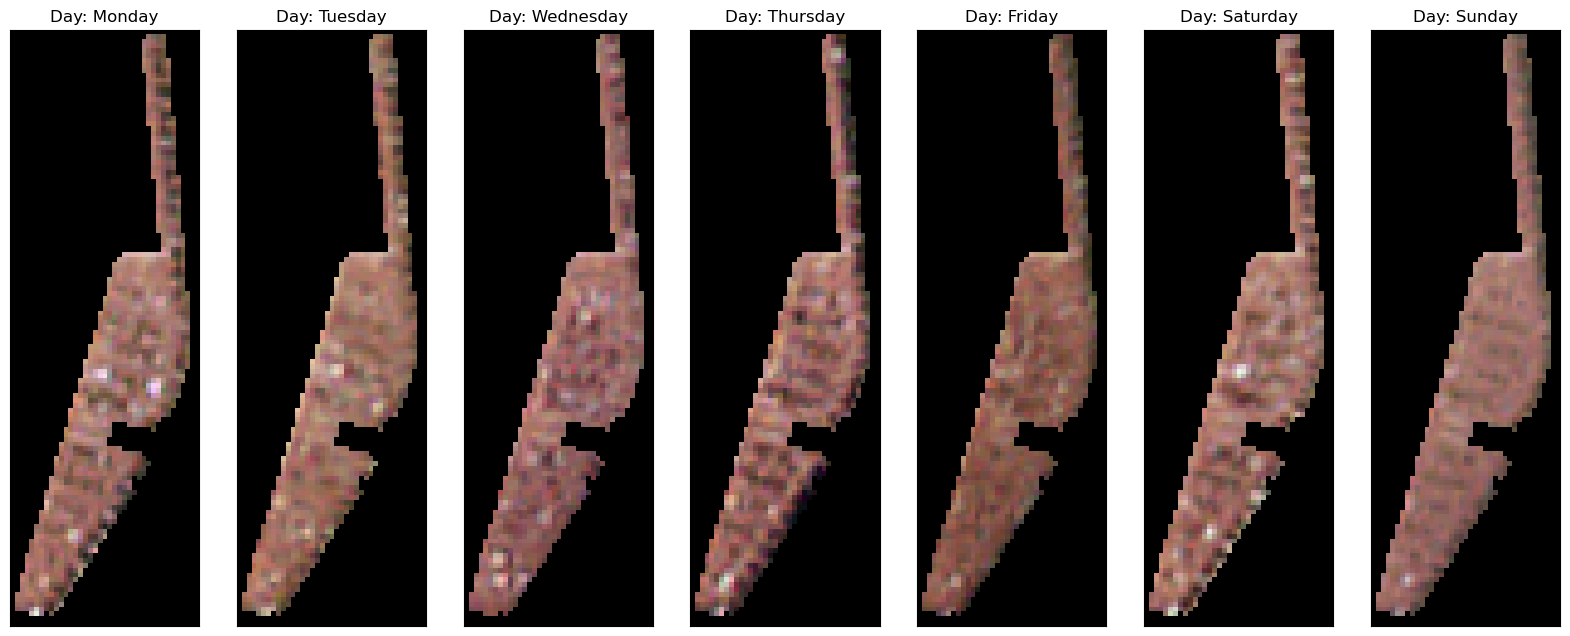

In [57]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(20,20))
for j,i in enumerate(days):
    plt.subplot(1,7,j+1)
    img = rioxarray.open_rasterio(df[df.day == i].image_path.values[0])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Day: {i}')
    plt.xticks([])
    plt.yticks([])

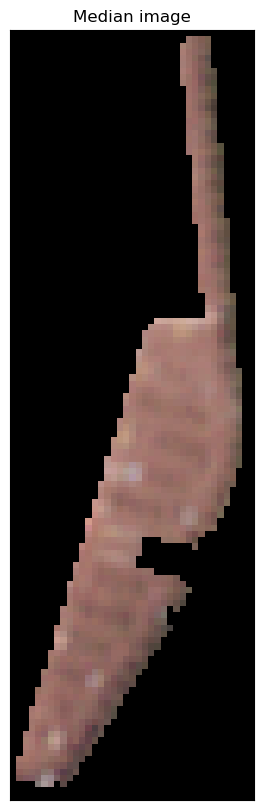

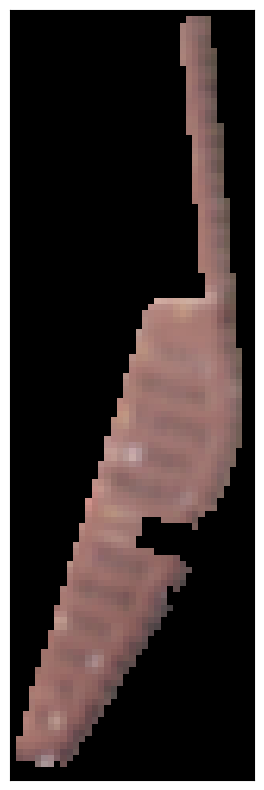

In [68]:
# Median image of all sundays in the dataset
sunday_images = df[df.label == 1].image_path.values
sunday_median, sunday_median_image = create_median_image(sunday_images)
plt.figure(figsize=(10,10))
plt.imshow(sunday_median_image)
plt.title("Median image")
plt.xticks([])
plt.yticks([])

#median image of all weekdays in the dataset
weekday_images = df.image_path.values
weekday_median, weekday_median_image = create_median_image(weekday_images)
plt.figure(figsize=(10,10))
plt.imshow(weekday_median_image)
plt.xticks([])
plt.yticks([])
plt.show()

In [51]:
img = rioxarray.open_rasterio(df[df.day == i].image_path.values[0])

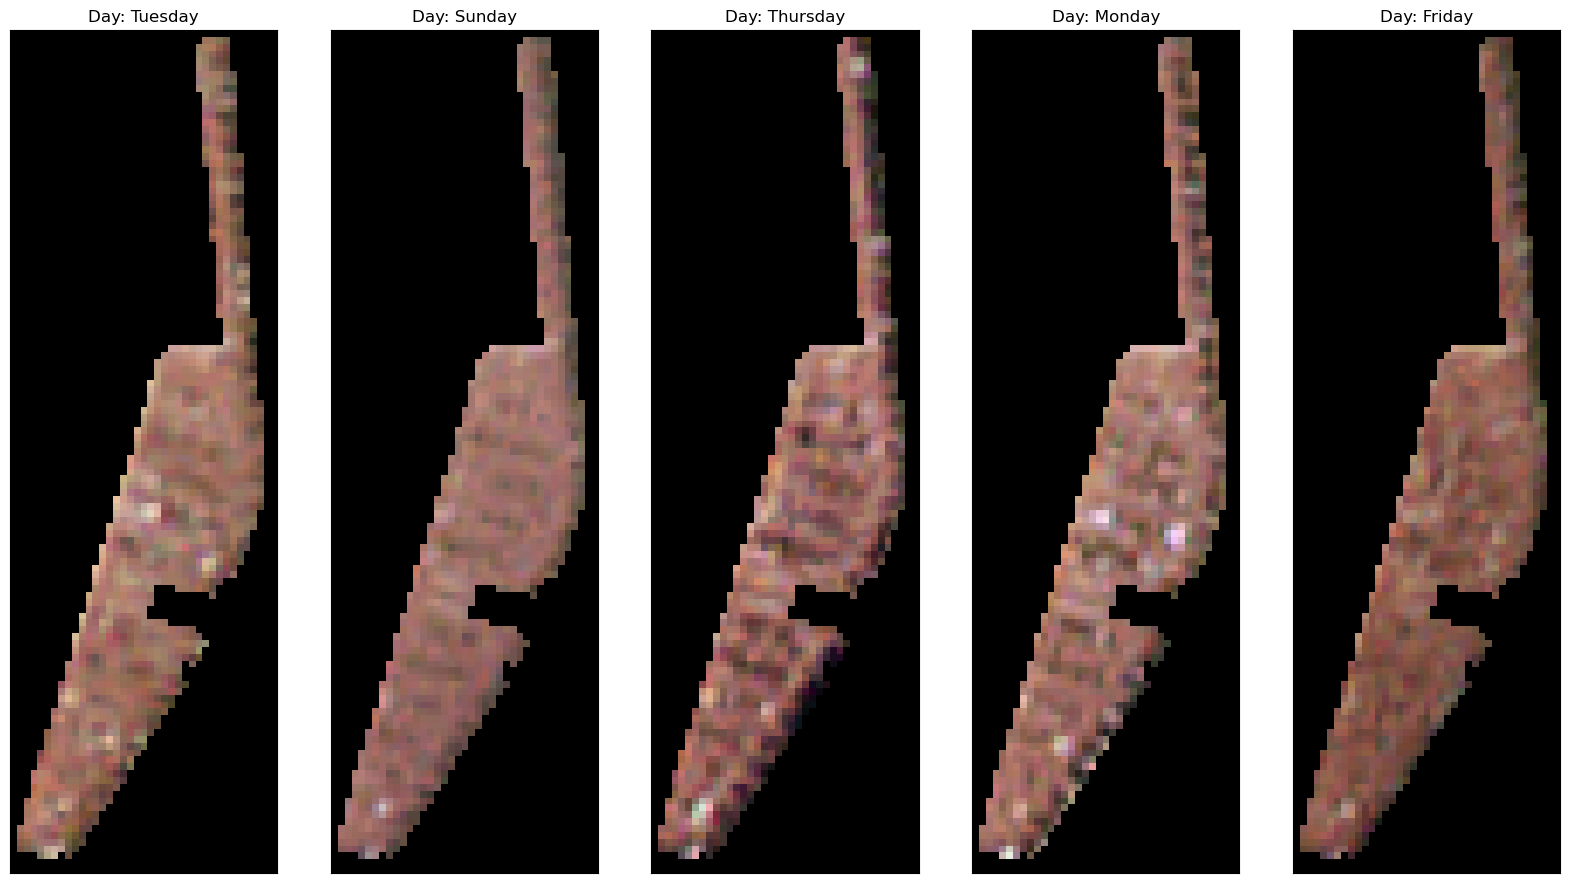

In [36]:
plt.figure(figsize=(20,20))

for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(df.image_path[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Day: {df.day[i]}')
    plt.xticks([])
    plt.yticks([])

In [10]:
#Checking the dimensions of the images
img = rioxarray.open_rasterio(masked_clean[i])
img.data[0:3].transpose(1, 2, 0).shape

(123, 39, 3)

In [11]:
img = rioxarray.open_rasterio(masked_clean[0])
image = img.data[0:3].transpose(1, 2, 0)
random_patches = extract_random_patches(image, patch_size=(20, 20), num_patches=15)
print(len(random_patches))

15


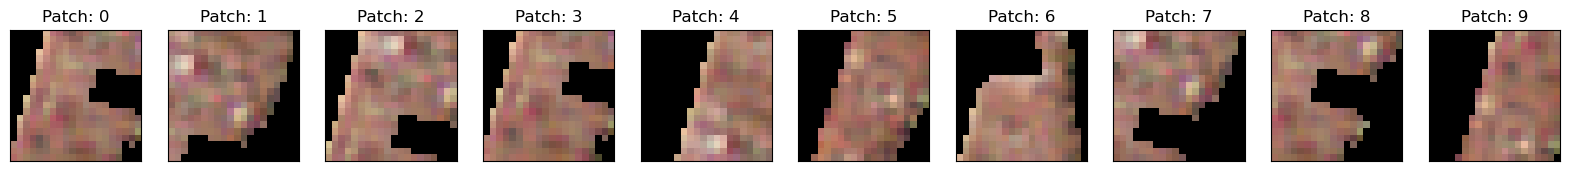

In [12]:
#plot these 10 random patches
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(random_patches[i])
    plt.title(f'Patch: {i}')
    plt.xticks([])
    plt.yticks([])

##### Method 1: Sunday vs others

In [13]:
#Creating labels for the dataset
df = label_csv(masked_clean)

Class distribution in dataset: 0    204
1     29
Name: label, dtype: int64


Training

In [14]:
class lr_car_detect_dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        img = rioxarray.open_rasterio(img_path)
        img = img.data[0:3].transpose(1, 2, 0)
        random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=1)
        # print('random is runing')
        label = self.df.label.values[idx]        
        if self.transform:
            img = self.transform(random_patches[0])
        return img, label


##### Augmentations and transforms

In [15]:
# Custom function for Gaussian blur
# from PIL import ImageFilter
### Will implement later

# class GaussianBlur(object):
#     def __init__(self, kernel_size=3):
#         self.kernel_size = kernel_size

#     def __call__(self, tensor):
#         img = transforms.ToPILImage()(tensor)
#         img_blurred = img.filter(ImageFilter.GaussianBlur(self.kernel_size))
#         return transforms.ToTensor()(img_blurred)

# # Custom function for adding Gaussian noise
# class AddGaussianNoise(object):
#     def __init__(self, mean=0, std=0.1):
#         self.mean = mean
#         self.std = std

#     def __call__(self, tensor):
#         noise = torch.randn_like(tensor) * self.std + self.mean
#         noisy_tensor = tensor + noise
#         return noisy_tensor
# combined_transform = transforms.Compose([
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random Brightness/Contrast Adjustment
#     transforms.RandomRotation(degrees=45),  # Random Rotation
#     transforms.RandomHorizontalFlip(p=0.5),  # Horizontal Flipping
#     transforms.RandomVerticalFlip(p=0.5),  # Vertical Flipping
#     GaussianBlur(kernel_size=3),  # Gaussian Blur
#     AddGaussianNoise(mean=0, std=0.1),  # Addition of Gaussian Noise
#     # You can add other necessary transformations here
# ])



train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),])

In [16]:
#train test split
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Train size: (186, 3)
Test size: (47, 3)
Train class distribution: 0    163
1     23
Name: label, dtype: int64
Test class distribution: 0    41
1     6
Name: label, dtype: int64


In [17]:
train_dataset = lr_car_detect_dataset(train, transform=train_transform)
test_dataset = lr_car_detect_dataset(test, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [18]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss = []
    train_acc = []
    train_auc = []
    val_loss = []
    val_acc = []
    val_auc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            y_pred = []
            y_true = []
            # Iterate over data.
            for inputs, labels in eval(phase+'_loader'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
            epoch_loss = running_loss / len(eval(phase+'_loader').dataset)
            epoch_acc = running_corrects.double() / len(eval(phase+'_loader').dataset)
            epoch_auc = roc_auc_score(y_true, y_pred)
            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_auc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_auc.append(epoch_auc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                # torch.save(model.state_dict(), '"patch_based_model_individial_parking.pt')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val AUC: {:4f}'.format(best_auc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc

In [48]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------
train Loss: 0.5577 Acc: 0.7688 AUC: 0.5694
test Loss: 0.8982 Acc: 0.8723 AUC: 0.5000
Epoch 1/199
----------
train Loss: 0.6166 Acc: 0.8710 AUC: 0.4969
test Loss: 0.5042 Acc: 0.8723 AUC: 0.5000
Epoch 2/199
----------
train Loss: 0.4835 Acc: 0.8333 AUC: 0.5128
test Loss: 0.5340 Acc: 0.8723 AUC: 0.5000
Epoch 3/199
----------
train Loss: 0.5209 Acc: 0.8656 AUC: 0.4939
test Loss: 0.9756 Acc: 0.8723 AUC: 0.5000
Epoch 4/199
----------
train Loss: 0.3513 Acc: 0.8763 AUC: 0.5000
test Loss: 1.6215 Acc: 0.8723 AUC: 0.5000
Epoch 5/199
----------
train Loss: 0.4897 Acc: 0.8763 AUC: 0.5000
test Loss: 0.3683 Acc: 0.8723 AUC: 0.5000
Epoch 6/199
----------
train Loss: 0.4047 Acc: 0.8710 AUC: 0.4969
test Loss: 0.4473 Acc: 0.8723 AUC: 0.5000
Epoch 7/199
----------
train Loss: 0.3540 Acc: 0.8710 AUC: 0.4969
test Loss: 0.3814 Acc: 0.7872 AUC: 0.6646
Epoch 8/199
----------
train Loss: 0.4288 Acc: 0.8656 AUC: 0.4939
test Loss: 0.3710 Acc: 0.8723 AUC: 0.5000
Epoch 9/199
----------
train

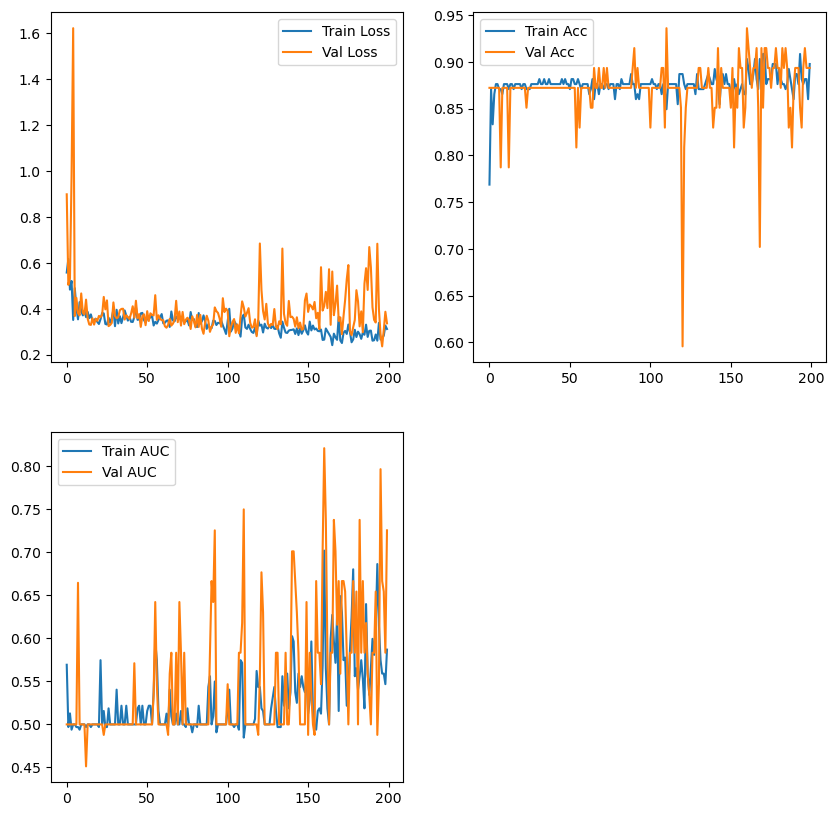

In [49]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#plotting the loss and accuracy curves, AUC scores for train and test set
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(train_acc_values, label='Train Acc')
plt.plot(val_acc_values, label='Val Acc')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Val AUC')
plt.legend()
plt.show()

- Conclusion: Maybe working

In [19]:
#Creating a big dataset of patches and doing only Saturday vs Sunday
df_2 = label_csv_2(masked_clean)

Class distribution in dataset: 1    29
0    26
Name: label, dtype: int64


In [23]:
path2new_data = "/home/akansh-i2sc/Desktop/Project/detect-car-LR/notebooks/Exp_7/patch_data_single_parking_lot_satvssun"
import os
if not os.path.exists(path2new_data):
    os.mkdir(path2new_data)
    os.mkdir(os.path.join(path2new_data, 'train'))
    os.mkdir(os.path.join(path2new_data, 'test'))
    os.mkdir(os.path.join(path2new_data, 'train', '0'))
    os.mkdir(os.path.join(path2new_data, 'train', '1'))
    os.mkdir(os.path.join(path2new_data, 'test', '0'))
    os.mkdir(os.path.join(path2new_data, 'test', '1'))
else:
    pass

In [20]:
train, test = train_test_split(df_2, test_size=0.2, random_state=42, stratify=df_2.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Train size: (44, 3)
Test size: (11, 3)
Train class distribution: 1    23
0    21
Name: label, dtype: int64
Test class distribution: 1    6
0    5
Name: label, dtype: int64


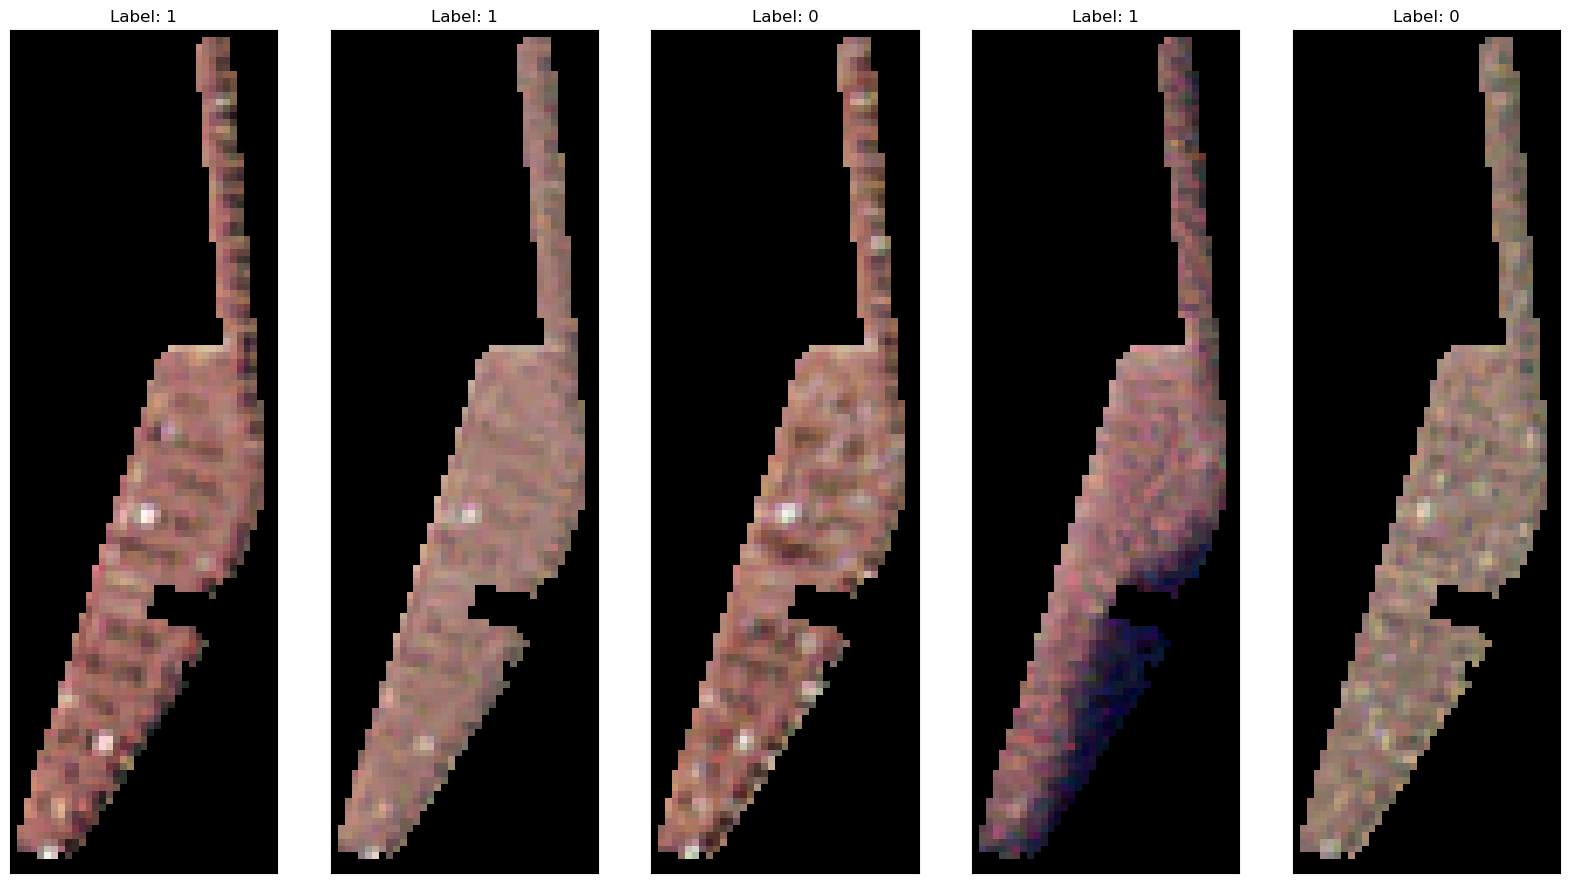

In [21]:
#plot images from train.image_path and train.label with labels
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(train.image_path.values[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Label: {train.label.values[i]}')
    plt.xticks([])
    plt.yticks([])

In [54]:
#use extract_random_patches function to create patches from the images and save them in the respective folders
for i in tqdm(range(len(train))):
    img_path = train.image_path.values[i]
    img = rioxarray.open_rasterio(img_path)
    img = img.data[0:3].transpose(1, 2, 0)
    random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=20)
    label = train.label.values[i]
    if label == 0:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'train', '0', f'{i}_{j}.png'), random_patches[j])
    else:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'train', '1', f'{i}_{j}.png'), random_patches[j])

for i in tqdm(range(len(test))):
    img_path = test.image_path.values[i]
    img = rioxarray.open_rasterio(img_path)
    img = img.data[0:3].transpose(1, 2, 0)
    random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=20)
    label = test.label.values[i]
    if label == 0:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'test', '0', f'{i}_{j}.png'), random_patches[j])
    else:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'test', '1', f'{i}_{j}.png'), random_patches[j])

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

<Figure size 2000x2000 with 0 Axes>

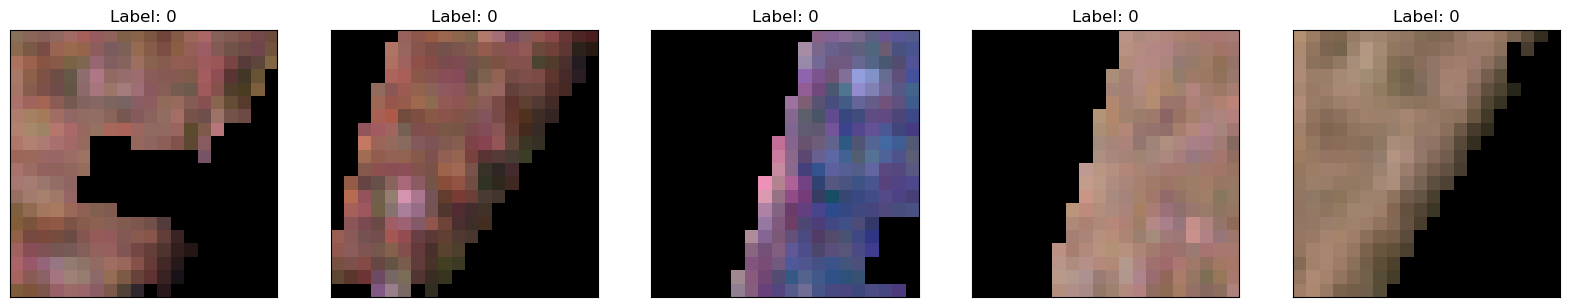

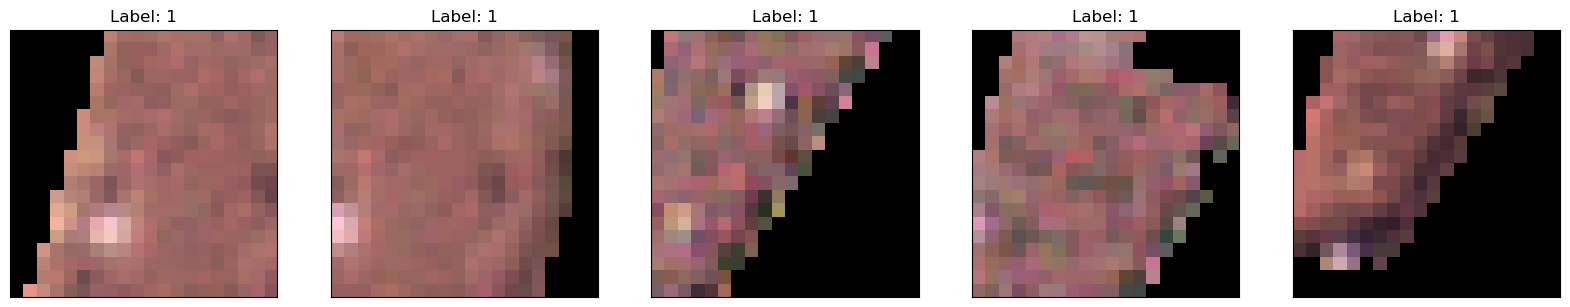

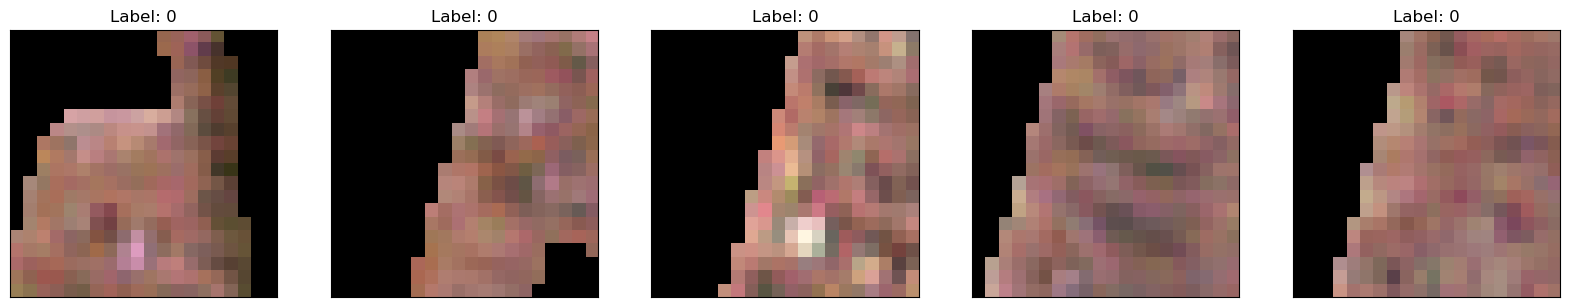

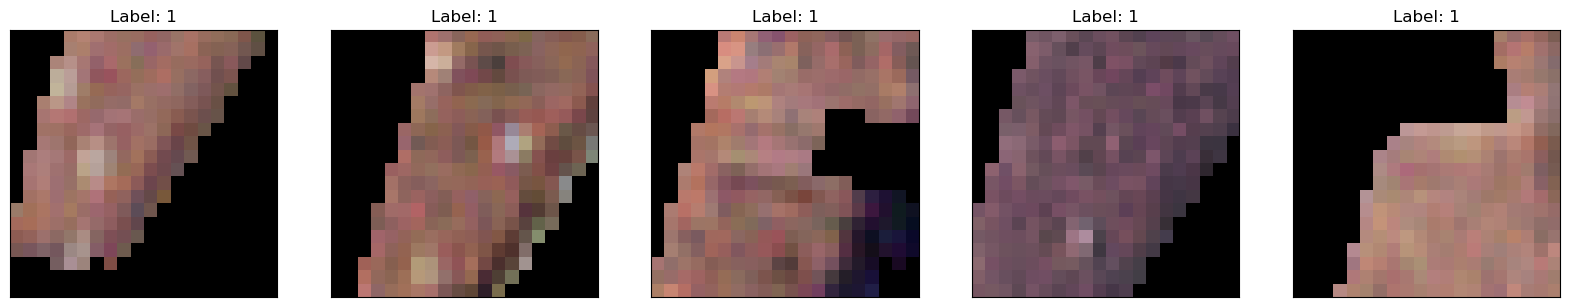

In [24]:
#plotting the patches from the trainset of both categories and putting them in a grid with labels
plt.figure(figsize=(20,20))
train_img_0 = glob.glob(os.path.join(path2new_data, 'train', '0', '*.png'))
train_img_1 = glob.glob(os.path.join(path2new_data, 'train', '1', '*.png'))

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(train_img_0[i])
    plt.imshow(img)
    plt.title(f'Label: 0')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(train_img_1[i])
    plt.imshow(img)
    plt.title(f'Label: 1')
    plt.xticks([])
    plt.yticks([])

#plotting the patches from the testset of both categories and putting them in a grid with labels
test_img_0 = glob.glob(os.path.join(path2new_data, 'test', '0', '*.png'))
test_img_1 = glob.glob(os.path.join(path2new_data, 'test', '1', '*.png'))

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(test_img_0[i])
    plt.imshow(img)
    plt.title(f'Label: 0')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = plt.imread(test_img_1[i])
    plt.imshow(img)
    plt.title(f'Label: 1')
    plt.xticks([])
    plt.yticks([])



In [25]:
#training model
train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'train'), transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'test'), transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

In [90]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------
train Loss: 0.7324 Acc: 0.5625 AUC: 0.5578
test Loss: 0.7087 Acc: 0.4545 AUC: 0.4733
Epoch 1/199
----------
train Loss: 0.6745 Acc: 0.6125 AUC: 0.6109
test Loss: 0.6495 Acc: 0.6455 AUC: 0.6392
Epoch 2/199
----------
train Loss: 0.6326 Acc: 0.6580 AUC: 0.6578
test Loss: 0.6142 Acc: 0.6727 AUC: 0.6717
Epoch 3/199
----------
train Loss: 0.5940 Acc: 0.6955 AUC: 0.6941
test Loss: 0.6064 Acc: 0.6864 AUC: 0.6933
Epoch 4/199
----------
train Loss: 0.5541 Acc: 0.7239 AUC: 0.7220
test Loss: 0.5648 Acc: 0.7091 AUC: 0.7050
Epoch 5/199
----------
train Loss: 0.5241 Acc: 0.7330 AUC: 0.7322
test Loss: 0.5728 Acc: 0.7000 AUC: 0.6825
Epoch 6/199
----------
train Loss: 0.5056 Acc: 0.7580 AUC: 0.7585
test Loss: 0.5410 Acc: 0.7500 AUC: 0.7450
Epoch 7/199
----------
train Loss: 0.5014 Acc: 0.7477 AUC: 0.7455
test Loss: 0.5496 Acc: 0.7364 AUC: 0.7300
Epoch 8/199
----------
train Loss: 0.4647 Acc: 0.7830 AUC: 0.7811
test Loss: 0.5572 Acc: 0.7227 AUC: 0.7117
Epoch 9/199
----------
train

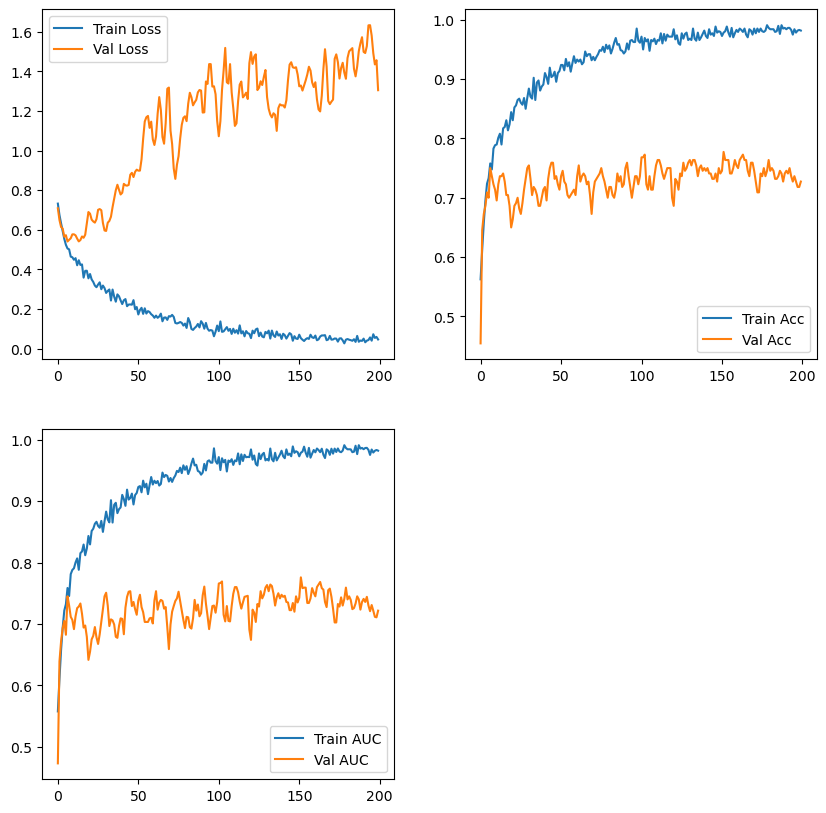

In [92]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#plotting the loss and accuracy curves, AUC scores for train and test set
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(train_acc_values, label='Train Acc')
plt.plot(val_acc_values, label='Val Acc')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Val AUC')
plt.legend()
plt.show()

Testing

Label of patch: 0


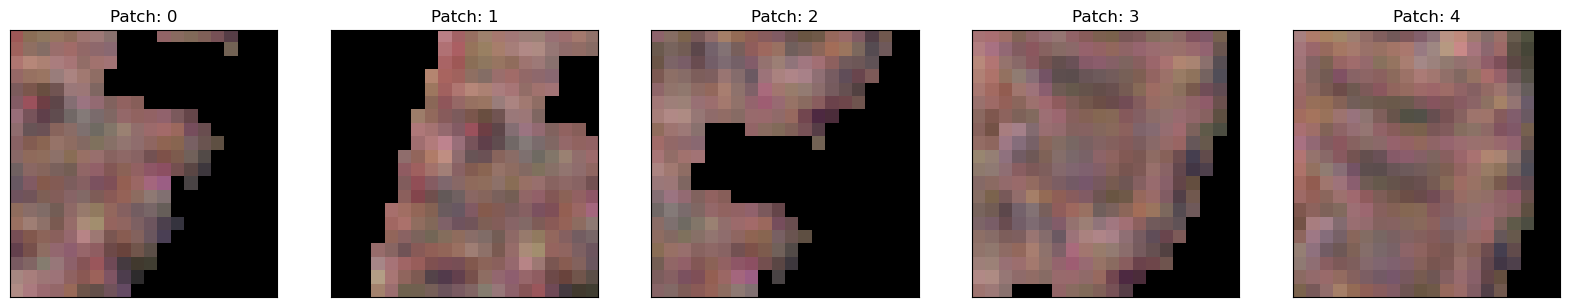

In [98]:
img = rioxarray.open_rasterio(test.image_path.values[0])
img = img.data[0:3].transpose(1, 2, 0)
random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=5)
print("Label of patch:", test.label.values[0])
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(random_patches[i])
    plt.title(f'Patch: {i}')
    plt.xticks([])
    plt.yticks([])

In [196]:
def inference(img, model, test_transform):
    model.eval()
    img = test_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    output = model(img)
    _, preds = torch.max(output, 1)
    return preds.item()

def inference_by_voting(img, num_patches = 5):
    img = rioxarray.open_rasterio(img)
    img = img.data[0:3].transpose(1, 2, 0)
    random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=num_patches)
    preds = []
    for i in random_patches:
        preds.append(inference(i, model, test_transform))
    # print(preds)
    # print(max(set(preds), key=preds.count))
    return max(set(preds), key=preds.count)


In [105]:
#add a column to the test dataframe with the predicted labels
test['pred_label'] = test.image_path.apply(lambda x: inference_by_voting(x))

In [107]:
accuracy_score(test.label.values, test.pred_label.values)

0.8181818181818182

AttributeError: 'DataFrame' object has no attribute 'pred_label'

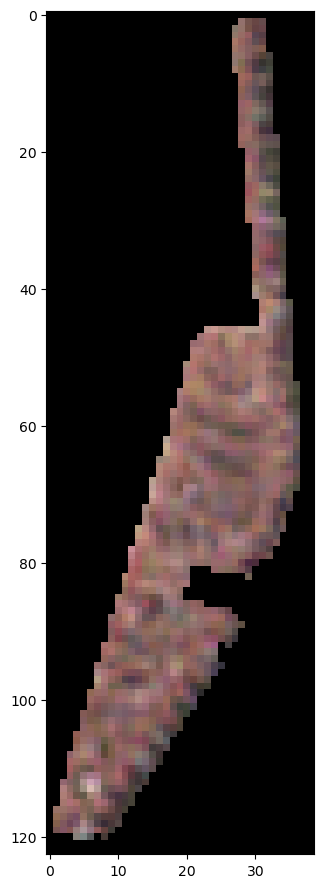

In [29]:
#plot images from test.image_path and test.pred_label with labels
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(test.image_path.values[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Label: {test.label.values[i]}, Pred Label: {test.pred_label.values[i]}')
    plt.xticks([])
    plt.yticks([])

#### Scaling to 2 parking lots

In [69]:
img_paths = ["/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_49_bbox/**/*.tif", '/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_538_bbox/**/*.tif']

In [70]:
masked = []
for img_path in img_paths:
    clean_1 = clean_data_by_size(img_path)
    clean_2 = clean_data_by_black_pixels(clean_1)
    clean_3 = clean_data_by_white_pixels(clean_2)
    masked_clean = [i for i in clean_3 if 'Masked' in i]
    print(len(masked_clean))
    masked.extend(masked_clean)

Initial size of dataset 500
Most common size of the dataset (4, 73, 49)
Final size of dataset(after removing faulty size images) 500
Final size of dataset(after removing faulty black pixels in images) 495
Final size of dataset(after removing faulty white pixels in images) 466
235
Initial size of dataset 500
Most common size of the dataset (4, 123, 39)
Final size of dataset(after removing faulty size images) 498
Final size of dataset(after removing faulty black pixels in images) 487
Final size of dataset(after removing faulty white pixels in images) 332
233


In [71]:
df = label_csv(masked)

Class distribution in dataset: 0    409
1     59
Name: label, dtype: int64


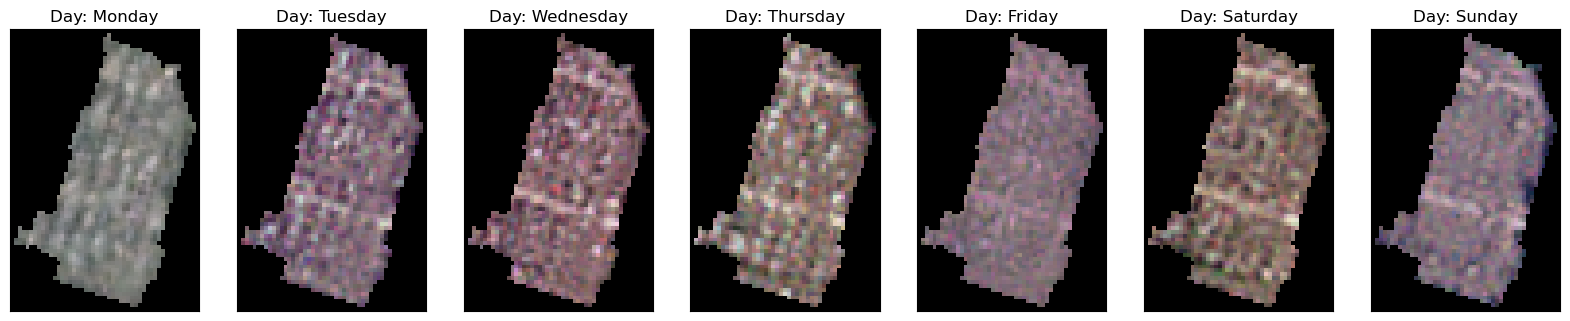

In [77]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(20,20))
for j,i in enumerate(days):
    plt.subplot(1,7,j+1)
    img = rioxarray.open_rasterio(df[df.day == i].image_path.values[2])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Day: {i}')
    plt.xticks([])
    plt.yticks([])

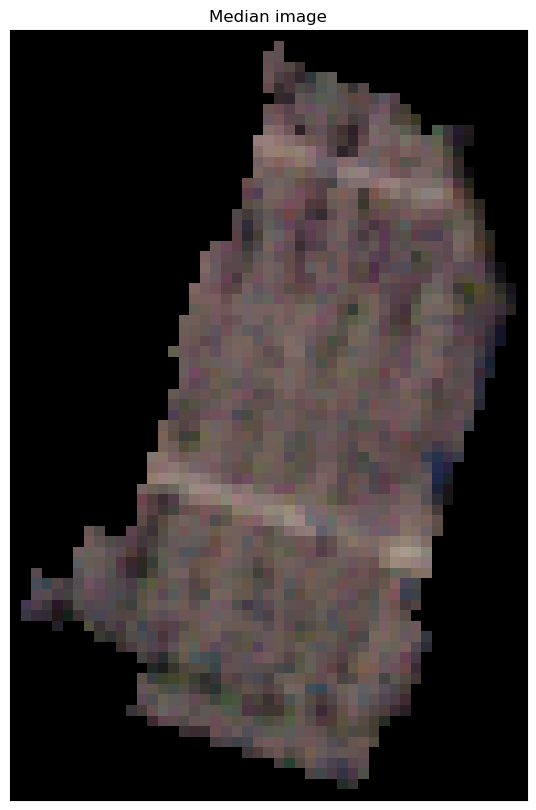

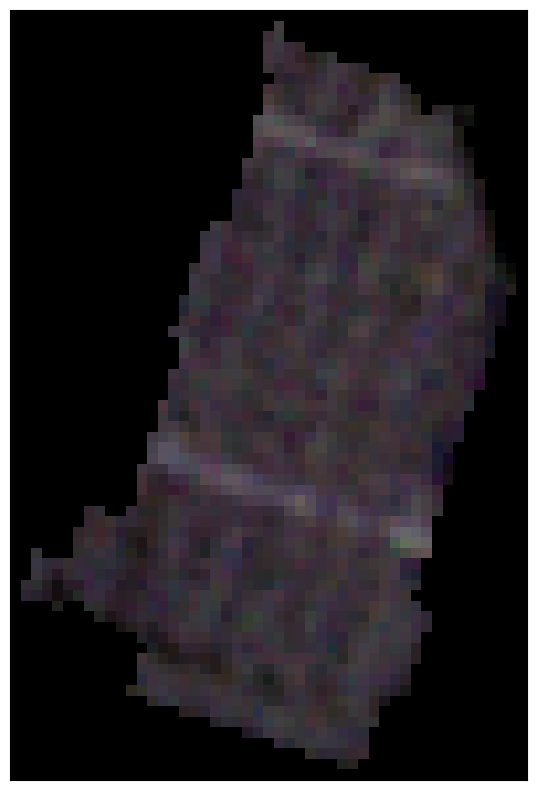

In [76]:
#median image of Sunday
sunday_images = df[df.label == 1].image_path.values
sunday_median, sunday_median_image = create_median_image(sunday_images)
plt.figure(figsize=(10,10))
plt.imshow(sunday_median_image)
plt.title("Median image")
plt.xticks([])
plt.yticks([])
plt.show()

#median image of weekdays
weekday_images = df.image_path.values
weekday_median, weekday_median_image = create_median_image(weekday_images)
plt.figure(figsize=(10,10))
plt.imshow(weekday_median_image)
plt.xticks([])
plt.yticks([])
plt.show()



In [122]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Train size: (374, 3)
Test size: (94, 3)
Train class distribution: 0    327
1     47
Name: label, dtype: int64
Test class distribution: 0    82
1    12
Name: label, dtype: int64


In [126]:
train_dataset = lr_car_detect_dataset(train, transform=train_transform)
test_dataset = lr_car_detect_dataset(test, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [127]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------
train Loss: 0.6338 Acc: 0.7754 AUC: 0.5072
test Loss: 0.4655 Acc: 0.8723 AUC: 0.5000
Epoch 1/199
----------
train Loss: 0.5312 Acc: 0.8717 AUC: 0.5076
test Loss: 0.5948 Acc: 0.8723 AUC: 0.5000
Epoch 2/199
----------
train Loss: 0.4326 Acc: 0.8743 AUC: 0.5000
test Loss: 0.6225 Acc: 0.8723 AUC: 0.5000
Epoch 3/199
----------
train Loss: 0.3836 Acc: 0.8717 AUC: 0.4985
test Loss: 0.3906 Acc: 0.8723 AUC: 0.5000
Epoch 4/199
----------
train Loss: 0.3794 Acc: 0.8743 AUC: 0.5000
test Loss: 0.4684 Acc: 0.8723 AUC: 0.5000
Epoch 5/199
----------
train Loss: 0.4226 Acc: 0.8743 AUC: 0.5000
test Loss: 0.4181 Acc: 0.8723 AUC: 0.5000
Epoch 6/199
----------
train Loss: 0.3692 Acc: 0.8743 AUC: 0.5000
test Loss: 0.3563 Acc: 0.8723 AUC: 0.5000
Epoch 7/199
----------
train Loss: 0.3833 Acc: 0.8743 AUC: 0.5000
test Loss: 0.3743 Acc: 0.8723 AUC: 0.5000
Epoch 8/199
----------
train Loss: 0.3812 Acc: 0.8636 AUC: 0.4939
test Loss: 0.3495 Acc: 0.8723 AUC: 0.5000
Epoch 9/199
----------
train

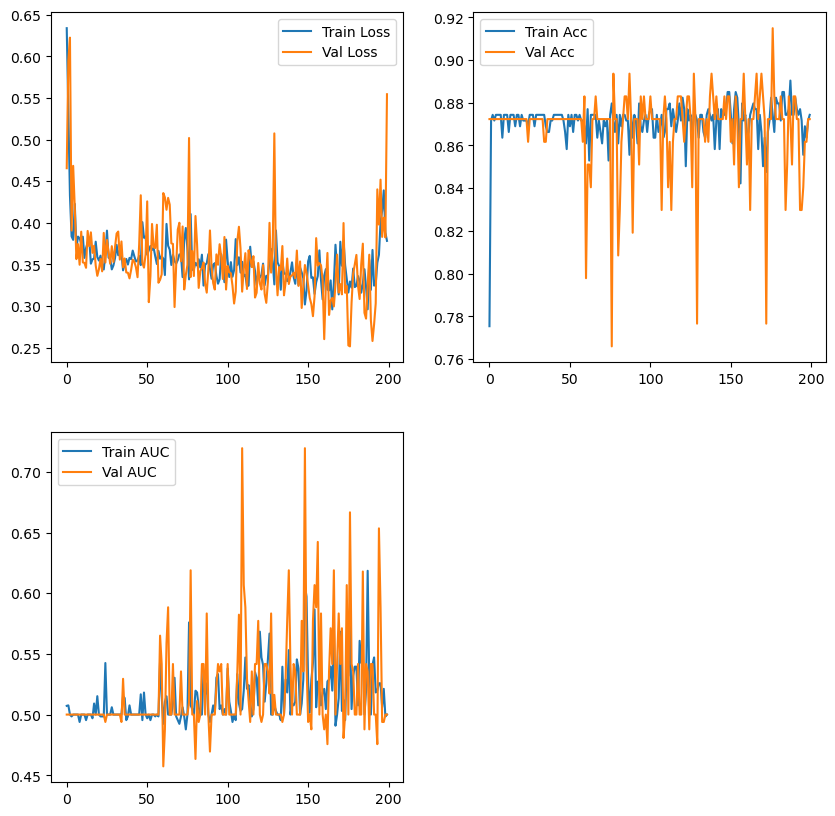

In [129]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#plotting the loss and accuracy curves, AUC scores for train and test set
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(train_acc_values, label='Train Acc')
plt.plot(val_acc_values, label='Val Acc')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Val AUC')
plt.legend()
plt.show()

In [130]:
df_2 = label_csv_2(masked)
path2new_data = "/home/akansh-i2sc/Desktop/Project/detect-car-LR/notebooks/Exp_7/patch_data_two_parking_lot_satvssun"
import os
if not os.path.exists(path2new_data):
    os.mkdir(path2new_data)
    os.mkdir(os.path.join(path2new_data, 'train'))
    os.mkdir(os.path.join(path2new_data, 'test'))
    os.mkdir(os.path.join(path2new_data, 'train', '0'))
    os.mkdir(os.path.join(path2new_data, 'train', '1'))
    os.mkdir(os.path.join(path2new_data, 'test', '0'))
    os.mkdir(os.path.join(path2new_data, 'test', '1'))
else:
    pass

Class distribution in dataset: 1    59
0    53
Name: label, dtype: int64


In [131]:
train, test = train_test_split(df_2, test_size=0.2, random_state=42, stratify=df_2.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Train size: (89, 3)
Test size: (23, 3)
Train class distribution: 1    47
0    42
Name: label, dtype: int64
Test class distribution: 1    12
0    11
Name: label, dtype: int64


In [132]:
#use extract_random_patches function to create patches from the images and save them in the respective folders
for i in tqdm(range(len(train))):
    img_path = train.image_path.values[i]
    img = rioxarray.open_rasterio(img_path)
    img = img.data[0:3].transpose(1, 2, 0)
    random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=20)
    label = train.label.values[i]
    if label == 0:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'train', '0', f'{i}_{j}.png'), random_patches[j])
    else:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'train', '1', f'{i}_{j}.png'), random_patches[j])

for i in tqdm(range(len(test))):
    img_path = test.image_path.values[i]
    img = rioxarray.open_rasterio(img_path)
    img = img.data[0:3].transpose(1, 2, 0)
    random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=20)
    label = test.label.values[i]
    if label == 0:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'test', '0', f'{i}_{j}.png'), random_patches[j])
    else:
        for j in range(len(random_patches)):
            plt.imsave(os.path.join(path2new_data, 'test', '1', f'{i}_{j}.png'), random_patches[j])

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [133]:
#training model
train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'train'), transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(path2new_data, 'test'), transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

In [134]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------
train Loss: 0.6987 Acc: 0.5994 AUC: 0.5985
test Loss: 0.6632 Acc: 0.6348 AUC: 0.6294
Epoch 1/199
----------
train Loss: 0.6441 Acc: 0.6629 AUC: 0.6580
test Loss: 0.7325 Acc: 0.6522 AUC: 0.6390
Epoch 2/199
----------
train Loss: 0.5807 Acc: 0.6865 AUC: 0.6838
test Loss: 0.7142 Acc: 0.6543 AUC: 0.6447
Epoch 3/199
----------
train Loss: 0.5682 Acc: 0.7096 AUC: 0.7049
test Loss: 0.7376 Acc: 0.6457 AUC: 0.6352
Epoch 4/199
----------
train Loss: 0.5522 Acc: 0.7152 AUC: 0.7116
test Loss: 0.7408 Acc: 0.6717 AUC: 0.6634
Epoch 5/199
----------
train Loss: 0.5292 Acc: 0.7298 AUC: 0.7255
test Loss: 0.6665 Acc: 0.6674 AUC: 0.6604
Epoch 6/199
----------
train Loss: 0.5107 Acc: 0.7545 AUC: 0.7510
test Loss: 0.6581 Acc: 0.6522 AUC: 0.6447
Epoch 7/199
----------
train Loss: 0.4977 Acc: 0.7551 AUC: 0.7521
test Loss: 0.6603 Acc: 0.6804 AUC: 0.6729
Epoch 8/199
----------
train Loss: 0.4871 Acc: 0.7579 AUC: 0.7547
test Loss: 0.6542 Acc: 0.6826 AUC: 0.6725
Epoch 9/199
----------
train

In [152]:
test['pred_label'] = test.image_path.apply(lambda x: inference_by_voting(x))
accuracy_score(test.label.values, test.pred_label.values)

[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0]
0
[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 1]
0
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0]
0
[0]
[0, 1]
[0, 1, 1]
[0, 1, 1, 0]
[0, 1, 1, 0, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 0]
[1, 1, 1, 0, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0]
0
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0]
0
[1]
[1, 0]
[1, 0, 1]
[1, 0, 1, 1]
[1, 0, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 0]
[1, 1, 1, 0, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
1
[1]
[1, 0]
[

0.8695652173913043

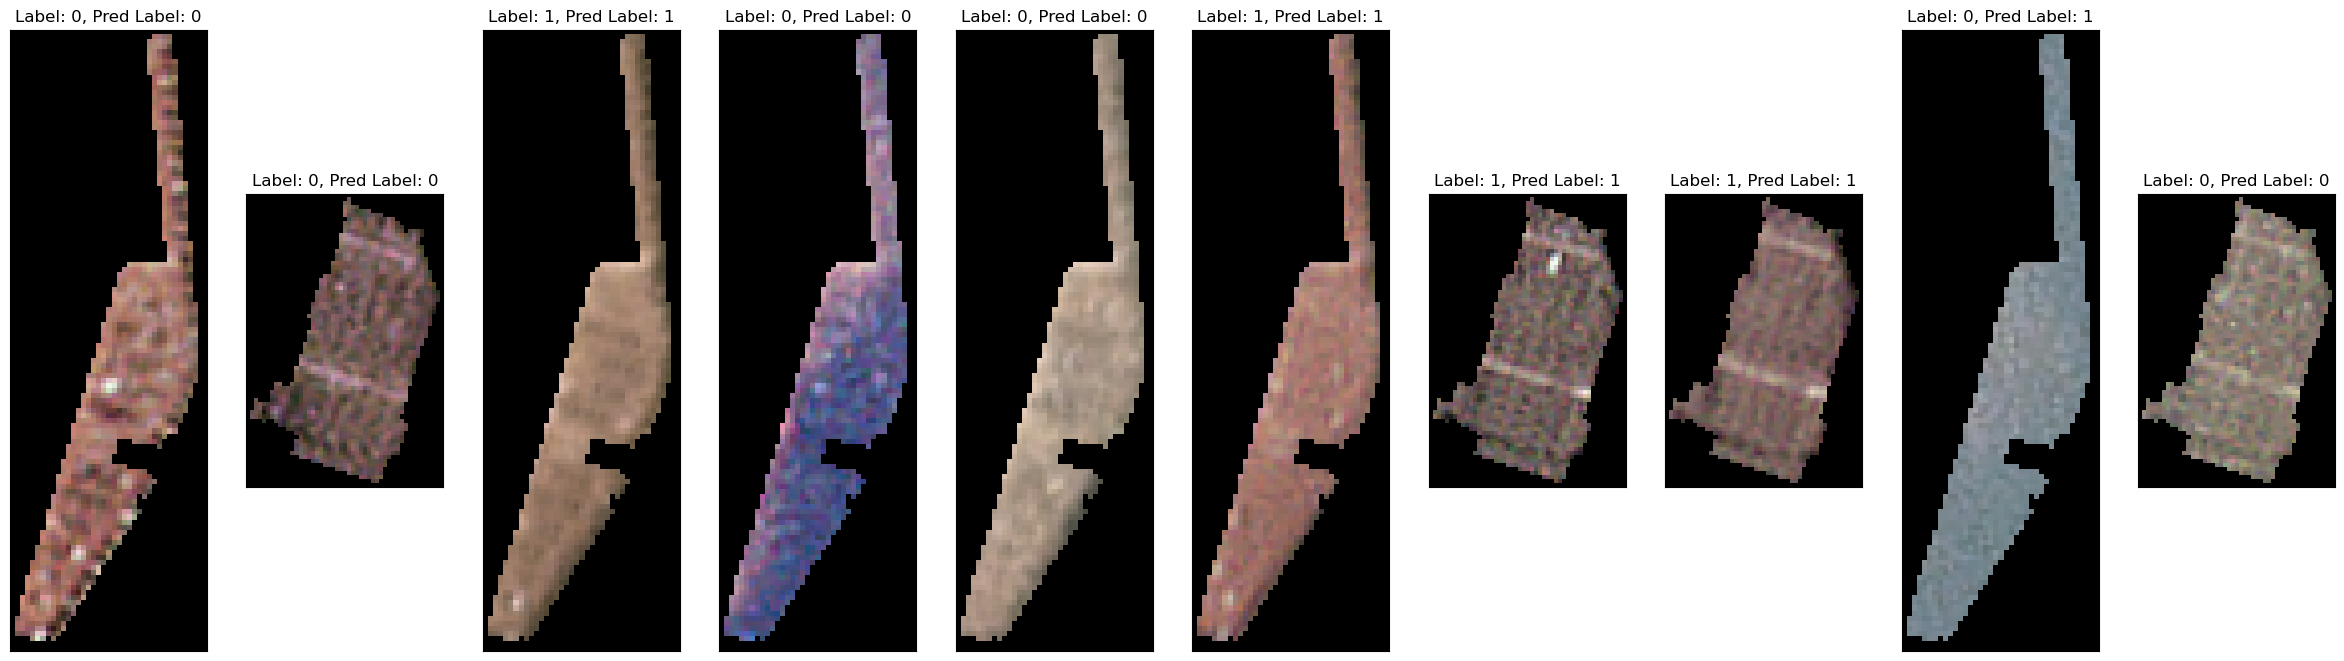

In [139]:
#plot images from test.image_path and test.pred_label with labels
plt.figure(figsize=(30,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    img = rioxarray.open_rasterio(test.image_path.values[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Label: {test.label.values[i]}, Pred Label: {test.pred_label.values[i]}')
    plt.xticks([])
    plt.yticks([])

#### Testing it on 3rd parking lot

In [155]:
third_park = '/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_60_bbox/**/*.tif'
clean_1 = clean_data_by_size(third_park)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

masked_clean_third = [i for i in clean_3 if 'asked' in i]

third_test = label_csv_2(masked_clean_third)

Initial size of dataset 750
Most common size of the dataset (4, 87, 89)
Final size of dataset(after removing faulty size images) 750
Final size of dataset(after removing faulty black pixels in images) 476
Final size of dataset(after removing faulty white pixels in images) 370
Class distribution in dataset: 0    46
1    44
Name: label, dtype: int64


In [180]:
third_test

,image_path,day,label,pred_label
0,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Sunday,1,1
1,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Sunday,1,0
2,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Sunday,1,1
3,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Saturday,0,0
4,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Saturday,0,0
...,...,...,...,...
85,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Sunday,1,1
86,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Saturday,0,0
87,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Saturday,0,0
88,/home/akansh-i2sc/Desktop/Project/detect-car-L...,Sunday,1,1


Accuracy score on Unseen set is:  0.6777777777777778
F1 score on Unseen set is:  0.7289719626168225
Confusion Matrix on Unseen set is:  [[22 24]
 [ 5 39]]


<Figure size 1000x1000 with 0 Axes>

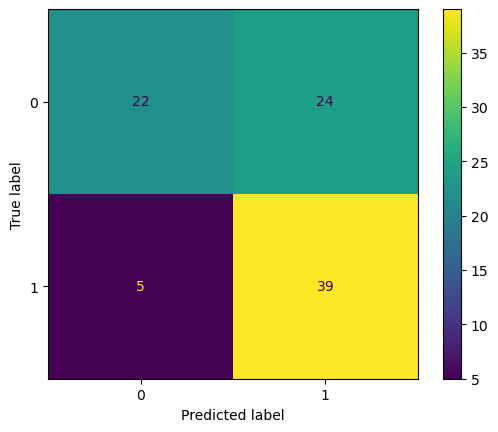

              precision    recall  f1-score   support

           0       0.81      0.48      0.60        46
           1       0.62      0.89      0.73        44

    accuracy                           0.68        90
   macro avg       0.72      0.68      0.67        90
weighted avg       0.72      0.68      0.66        90



In [198]:
model.eval()
third_test['pred_label'] = third_test.image_path.apply(lambda x: inference_by_voting(x, num_patches=5))

print("Accuracy score on Unseen set is: ", accuracy_score(third_test.label.values, third_test.pred_label.values))
print('F1 score on Unseen set is: ', f1_score(third_test.label.values, third_test.pred_label.values))
print('Confusion Matrix on Unseen set is: ', confusion_matrix(third_test.label.values, third_test.pred_label.values))

# plot the confusion matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(third_test.label.values, third_test.pred_label.values, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()
print(classification_report(third_test.label.values, third_test.pred_label.values))

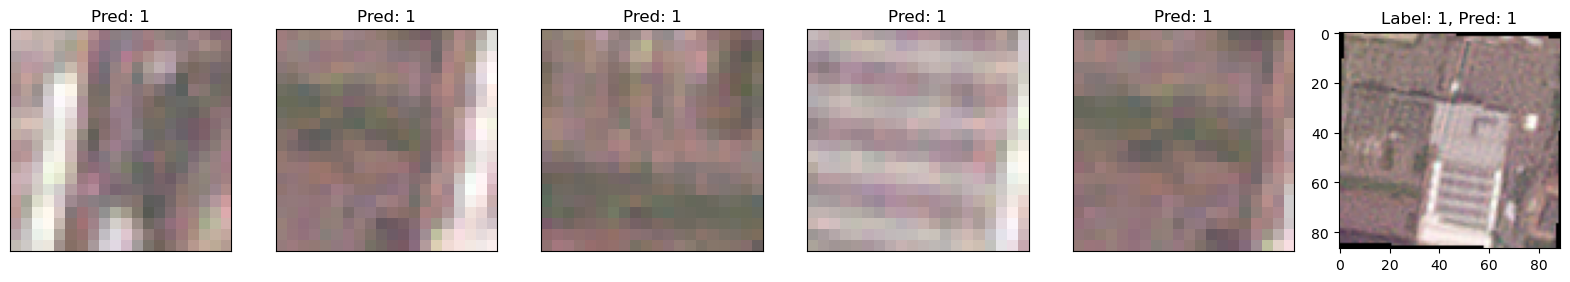

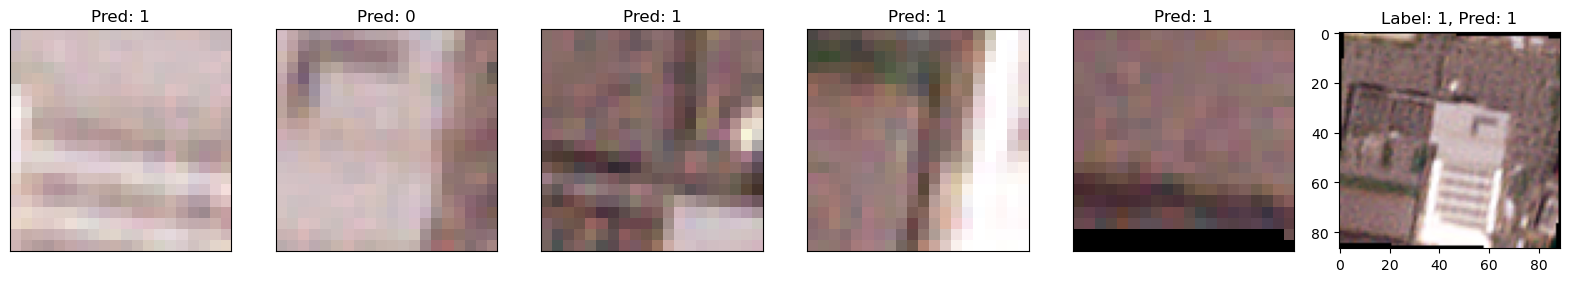

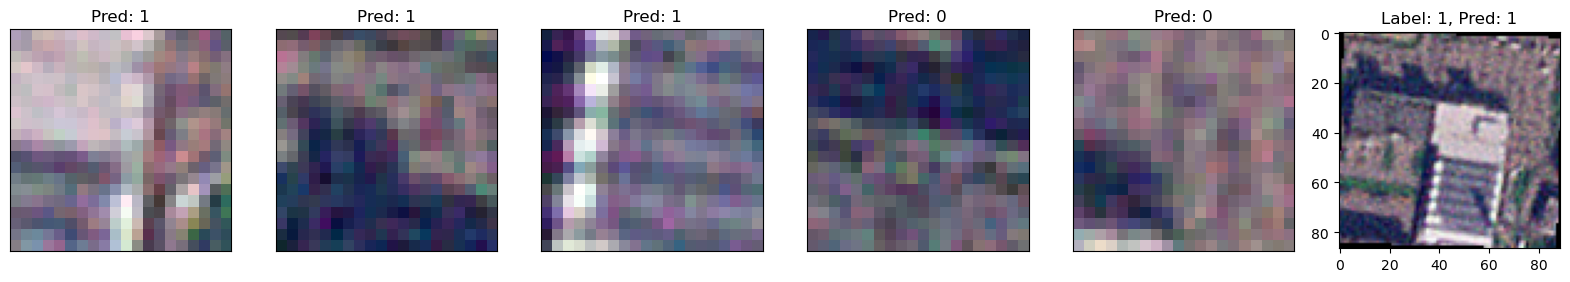

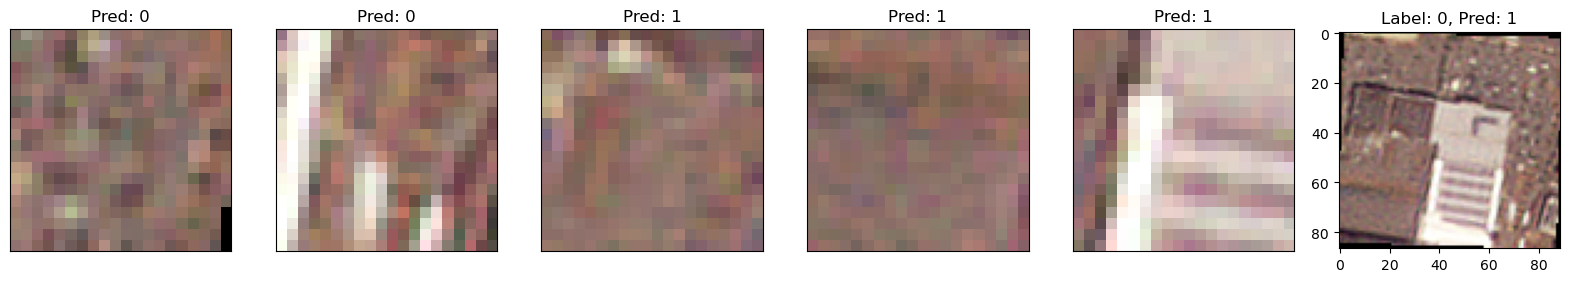

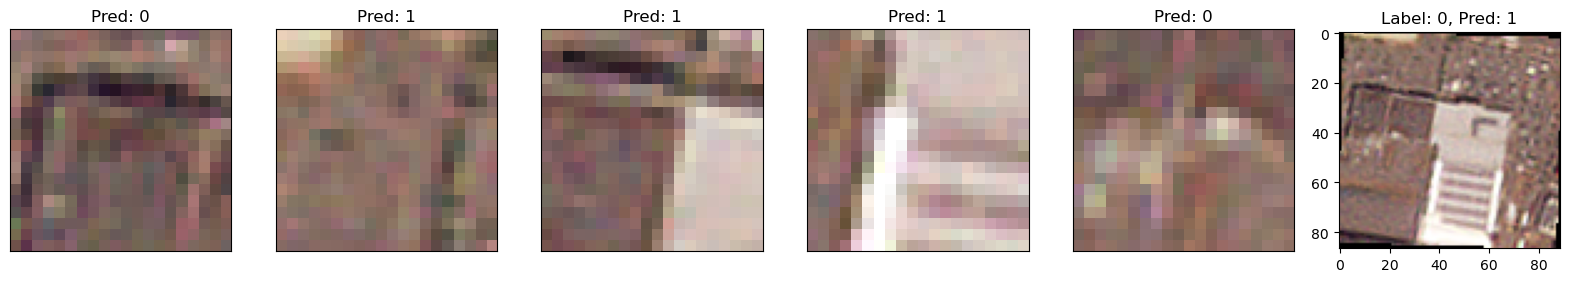

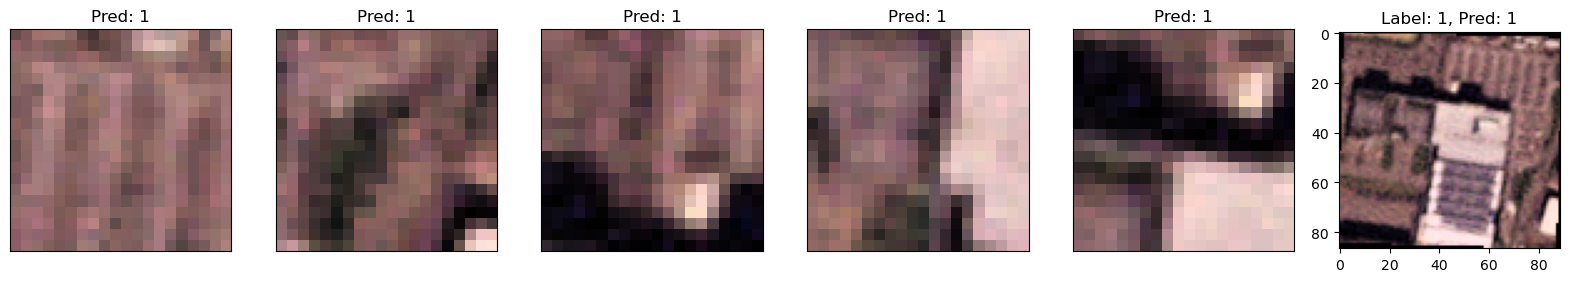

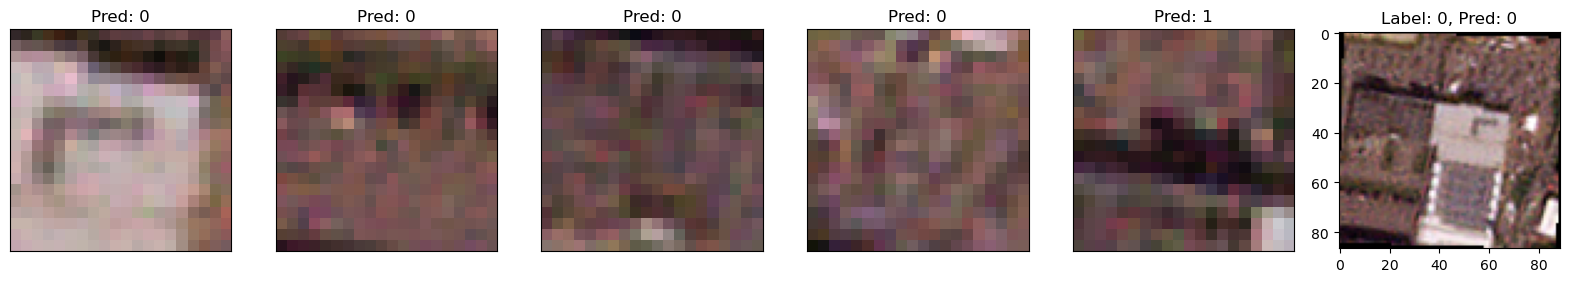

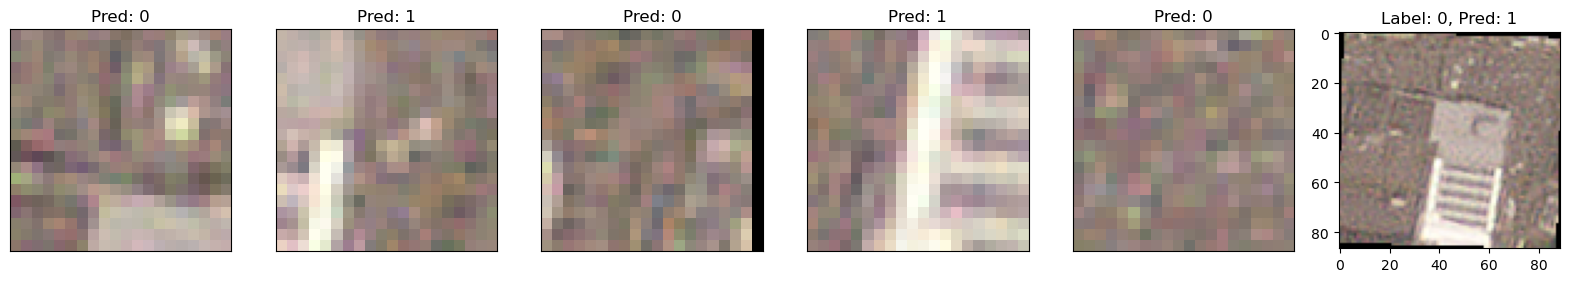

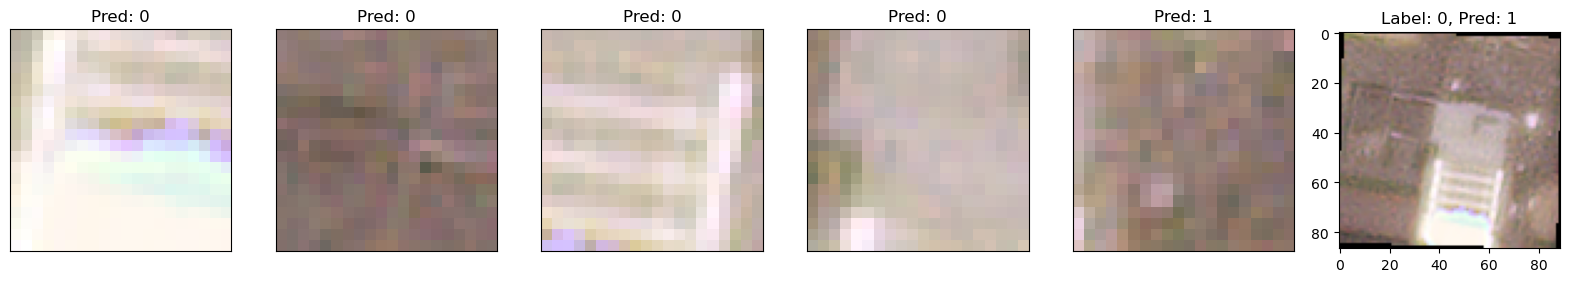

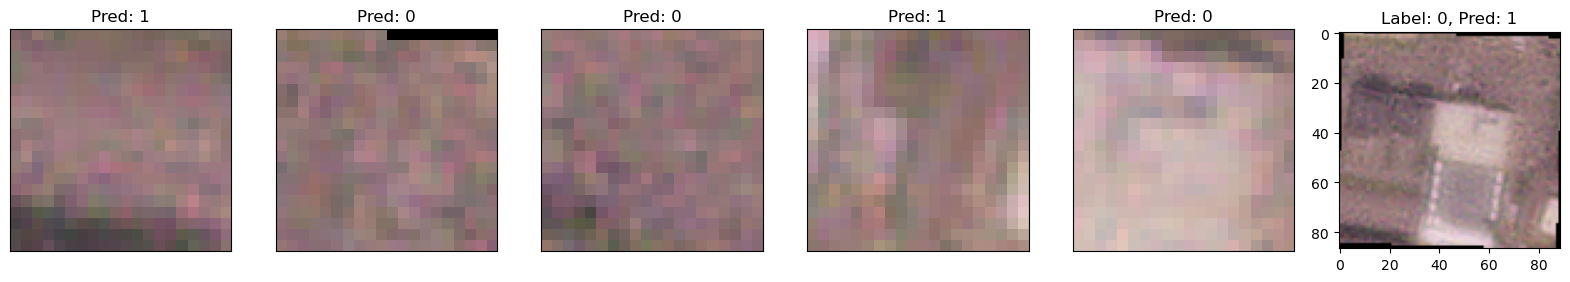

In [194]:
#Checking predictions on each patch, ploting and them
for j in range(0,10):
    img = rioxarray.open_rasterio(third_test.image_path.values[j])
    img = img.data[0:3].transpose(1, 2, 0)
    random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=5)
    plt.figure(figsize=(20,20))
    for i in range(5):
        plt.subplot(1,6,i+1)
        plt.imshow(random_patches[i])
        plt.title(f'Pred: {inference(random_patches[i], model, test_transform)}')
        plt.xticks([])
        plt.yticks([])
    plt.subplot(1,6,6)
    plt.imshow(img)
    plt.title(f'Label: {third_test.label.values[j]}, Pred: {third_test.pred_label.values[j]}')

Conclusion 
- I think it worked. Try it on more parking lot with bigger curated data. 
- Need to change the random square to something else. 
- 

#### Add more parking lots

In [140]:
img_paths = ["/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_49_bbox/**/*.tif", "/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_538_bbox/**/*.tif", '/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_60_bbox/**/*.tif']
masked = []
for img_path in img_paths:
    clean_1 = clean_data_by_size(img_path)
    clean_2 = clean_data_by_black_pixels(clean_1)
    clean_3 = clean_data_by_white_pixels(clean_2)
    masked_clean = [i for i in clean_3 if 'Masked' in i]
    print(len(masked_clean))
    masked.extend(masked_clean)
